# Inference on the Mass Distribution of Galactic Double Neutron Stars
In this demo we investigate mass distribution models under the hypothesis that Recycled and Non-recycled neautron stars have differing mass distributions. We compare two sub-hypotheses for the mass distribution of *recycled (fast)* and *non-recycled (slow)* Neutron Stars from Galactic Double Neutron Star (DNS) systems. The sub-hypotheses we compare are:

1. Recycled NS distribution is two-Gaussian (bimodal) and non-recycled is uniform. (Most favoured hypothesis in our findings)
2. Recycled & non-recycled are both single-Gaussian distributions. (Conventional)

However this code can easily be altered to compare any other two sub-hypotheses by changing the models investigated through replacing occurences of:
> models.uniformList
>
> models.___________List

into models of your choosing. Infact you can investigate your own models by writing a function in models.py (as long as you introduce an appropriate prior!)

### Requirements (Imports)

In [1]:
# We require functions for uniform, truncated gaussian, and truncated two-gaussian models.
import models

# We sample using pymultinest
import pymultinest

# Useful librarys for mathematical operations
import numpy as np
from scipy import stats
from scipy.special import erf
import random

# Filesystem operations
import os
import sys

We also load the mass samples:

In [2]:
# Load DNS mass samples
bothMassSamples = np.load('Samples/bothMassSamples.npy')
# For each DNS, pulsar & companion samples are grouped in pairs.
# Creates array of shape like (17x10000x2) (17 DNSs x 10000 observation samples x 2 (pulsar + companion))

# Only use 200 samples for faster sampling
massSamples = bothMassSamples[:,:200,:]

# Define the nMeasurements and nSamples per mass measurement
nSamples, nMeasurements = len(massSamples[0]), len(massSamples)

# Prior

Here we define prior used in this hypothesis. In this demo as we are exploring sub-hypotheses between **pairs of models**, therefore we run PyMultiNest with a set of hyperparameters which contains the parameters describing both models.

In [3]:
def prior(cube, ndim, nparams):
    # cube is initially a unit hypercube which is to be mapped onto the relevant prior space.
    
    # j is the hyperparameter index. We map the priors beginning with the parameters of model1,
    # and then incriment j by the number of parameters in that model1. Then mapping
    # the parameters of the next model2.
    j = 0
    
    # Loop over both models in the sub-hypothesis.
    for modelBeingMapped in [modelName1, modelName2]:
        if modelBeingMapped == 'singleGaussian':
            cube[j] = 0.8 + cube[j] * (2 - 0.8)
            cube[j+1] = 0.005 + cube[j+1] * (0.5 - 0.005)
            j += 2
        if modelBeingMapped == 'twoGaussian':
            cube[j] = 0.8 + cube[j] * (2 - 0.8)
            cube[j+1] = cube[j] + cube[j+1] * (2 - cube[j])
            cube[j+2] = 0.005 + cube[j+2] * (0.5 - 0.005)
            cube[j+3] = 0.005 + cube[j+3] * (0.5 - 0.005)
            cube[j+4] = cube[j+4] * 1
            j += 5
        if modelBeingMapped == 'uniform':
            cube[j] = 0.8 + cube[j] * (2 - 0.8)
            cube[j+1] = cube[j] + cube[j+1] * (2 - cube[j])
            j += 2

    return

# Likelihood Function

Here we impliment the likelihood function given by *Equation 11*.


In [4]:
def likelihood(cube, ndim, nparams):
    
    # Create lists of the parameters for each model. Model1 has parameters in cube from 0 to ndim1-1, Model2 has parameters in cube from ndim1 to ndim-1.
    paramList1 = [cube[i] for i in range(ndim1)]
    paramList2 = [cube[i] for i in range(ndim1, ndim)]
    
    # Initial list to contain the sum of the products of the probability for each m_r and m_s sample in their respective models.
    pdfProductSumList = []
    
    # For the m_r and m_s pairs in each BNS system. (eg. 1000x2)
    for massSample in massSamples:
        
        # Evaluate the PDF function down the m_r and m_s samples of the BNS
        mrProbabilities = modelEval1(paramList1, massSample[:,0])
        msProbabilities = modelEval2(paramList2, massSample[:,1])
        
        # Evaluate the product of the m_r and m_s probability for each pair.
        probabilityProduct = mrProbabilities*msProbabilities
        
        # Append the sum over all the probability products of each pair.
        pdfProductSumList.append(np.sum(probabilityProduct))
    
    # If either the m_r or the m_s samples are completely outside their model then return a log-likelihood of -inf.
    if 0 in pdfProductSumList:
        #print("Zero probability value - Parameters: {}, {}".format(paramList1,paramList2))
        return -np.inf
 
    # The log-likelihood is the log of the normalised sum over the log of each pdfProductSum
    loglikelihood = nMeasurements * np.log(1.0/nSamples) + np.sum(np.log(pdfProductSumList))
    return loglikelihood

# Inference

## Hypothesis #1, that recycled NS distribution is two-Gaussian (bimodal) and non-recycled is uniform.

This sampling can be quite computationally expensive, sampling speed can be an issue particularly inside Jupyter notebooks. Therefore for this demonstration the number of livepoints is reduced to 500. If this takes too long try 100 livepoints which should take 10-15 minutes. However reducing the livepoints will result in less continuous and more jagged posterior distributions.


Unfortunately the ouput from pymultinest is directed to the terminal (where jupyter is started), so it can not be seen in this notebook. However an example of the output is given below:

In [5]:
modelName1, modelEval1, ndim1, paramNames1 = models.twoGaussianList
modelName2, modelEval2, ndim2, paramNames2 = models.uniformList

# Define the total number of hyperparameters
ndimHyp1 = ndim1 + ndim2

### Inference
# Directory to send output to. Create it if it does not exist.
directoryNameHyp1 = 'hypo1/' + modelName1[:4] + "/" + modelName2[:4]
if not os.path.exists(directoryNameHyp1):
    os.makedirs(directoryNameHyp1)

In [ ]:
# Run pymultinest sampling
pmObject = pymultinest.run(likelihood, prior, ndimHyp1, n_live_points=500, sampling_efficiency=0.3, importance_nested_sampling=False, outputfiles_basename=directoryNameHyp1 + '/', verbose=True, resume=False)

In [6]:
egOutput = '''
*****************************************************
MultiNest v3.10
Copyright Farhan Feroz & Mike Hobson
Release Jul 2015

no. of live points =  100
dimensionality =    7
resuming from previous job
*****************************************************
Starting MultiNest
generating live points
live points generated, starting sampling
Acceptance Rate:                        0.955414
Replacements:                                150
Total Samples:                               157
Nested Sampling ln(Z):                 -6.272028
Acceptance Rate:                        0.271370
Replacements:                                400
Total Samples:                              1474
Nested Sampling ln(Z):                 10.303706
'''

## Hypothesis #2, that recycled & non-recycled are both single-Gaussian distributions. 

In [7]:
modelName1, modelEval1, ndim1, paramNames1 = models.singleGaussianList
modelName2, modelEval2, ndim2, paramNames2 = models.singleGaussianList

# Define the total number of hyperparameters
ndimHyp2 = ndim1 + ndim2

### Inference
# Directory to send output to. Create it if it does not exist.
directoryNameHyp2 = 'hypo2/' + modelName1[:4] + "/" + modelName2[:4]
if not os.path.exists(directoryNameHyp2):
    os.makedirs(directoryNameHyp2)

In [ ]:
# Run pymultinest sampling
pmObject = pymultinest.run(likelihood, prior, ndimHyp2, n_live_points=500, sampling_efficiency=0.3, importance_nested_sampling=False, outputfiles_basename=directoryNameHyp2 + '/', verbose=True, resume=False)

# Analysis

In [9]:
# We load the results for each hypothesis which were created by pymultinest
hyp1Res = pymultinest.analyse.Analyzer(ndimHyp1, outputfiles_basename=directoryNameHyp1 + '/')
hyp1Stats = hyp1Res.get_stats()
hyp2Res = pymultinest.analyse.Analyzer(ndimHyp2, outputfiles_basename=directoryNameHyp2 + '/')
hyp2Stats = hyp2Res.get_stats()

print("For Hypothesis 1 we find a log-Bayes Evidence: {}".format(hyp1Stats['global evidence']))
print("For Hypothesis 2 we find a log-Bayes Evidence: {}".format(hyp2Stats['global evidence']))

logBF = np.round(hyp1Stats['global evidence'] - hyp2Stats['global evidence'], 1)

print(
"""
Here we have shown that Hypothesis 1 (two-Gaussian recycled, uniform non-recycled) is strongly favoured
over the alternative hypothesis (single-gaussian distributions) with a Bayes Factor of {}, (log-BF: {})
""".format(np.round(np.exp(logBF), 1), logBF))

  analysing data from hypo1/twoG/unif/.txt
  analysing data from hypo2/sing/sing/.txt
For Hypothesis 1 we find a log-Bayes Evidence: 24.2533062226
For Hypothesis 2 we find a log-Bayes Evidence: 19.4291942354

Here we have shown that Hypothesis 1 (two-Gaussian recycled, uniform non-recycled) is strongly favoured
over the alternative hypothesis (single-gaussian distributions) with a Bayes Factor of 121.5, (log-BF: 4.8)



## We can also explore the parameter posteriors to view their distributions:
We make use of a library called corner plots which allows us to create corner plots, showing joint distributions which allows us to view slices of the sampling parameter space.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import corner


def cornerPlot(samples, bounds, parameterNames):
    plt.rcParams.update({'font.size': 15})
    return corner.corner(samples, bins=50, smooth=0.9, label_kwargs=dict(fontsize=16), show_titles=True, range=bounds, title_kwargs=dict(fontsize=16), color='#3fcca6', labels=parameterNames, plot_density=False, plot_datapoints=True, fill_contours=True, max_n_ticks=5)

hyp1Posterior = np.asarray([param for param in hyp1Res.get_equal_weighted_posterior()])
hyp2Posterior = np.asarray([param for param in hyp2Res.get_equal_weighted_posterior()])

## Hypothesis #2 Posterior

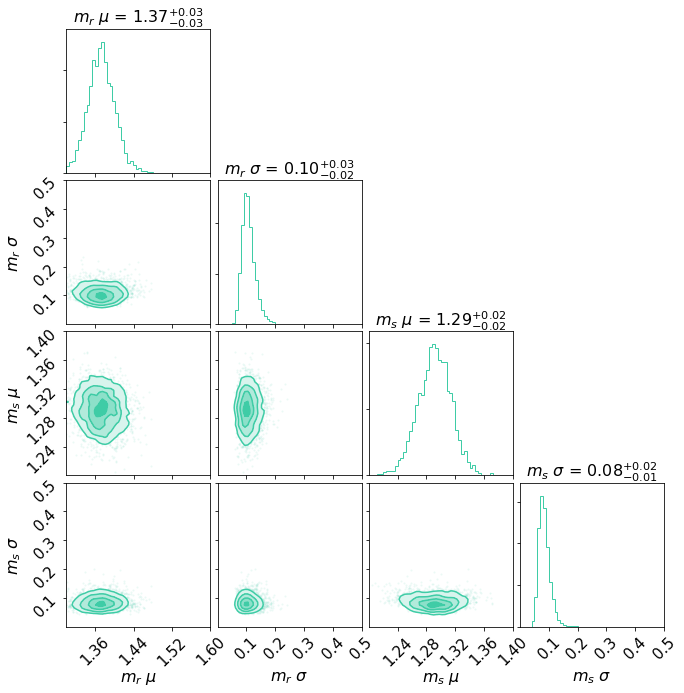

In [13]:
# We have to reset the model information back to hypothesis 2 information
modelName1, modelEval1, ndim1, paramNames1 = models.singleGaussianList
modelName2, modelEval2, ndim2, paramNames2 = models.singleGaussianList
paramNames1 = [r'$m_r$ ' + pName for pName in paramNames1]
paramNames2 = [r'$m_s$ ' + pName for pName in paramNames2]

cornerPlot(hyp2Posterior[:,:ndim1 + ndim2], bounds=[[1.3,1.6],[0,0.5], [1.2,1.4],[0,0.5]], parameterNames=paramNames1+paramNames2).show()

## Hypothesis #1 Posterior

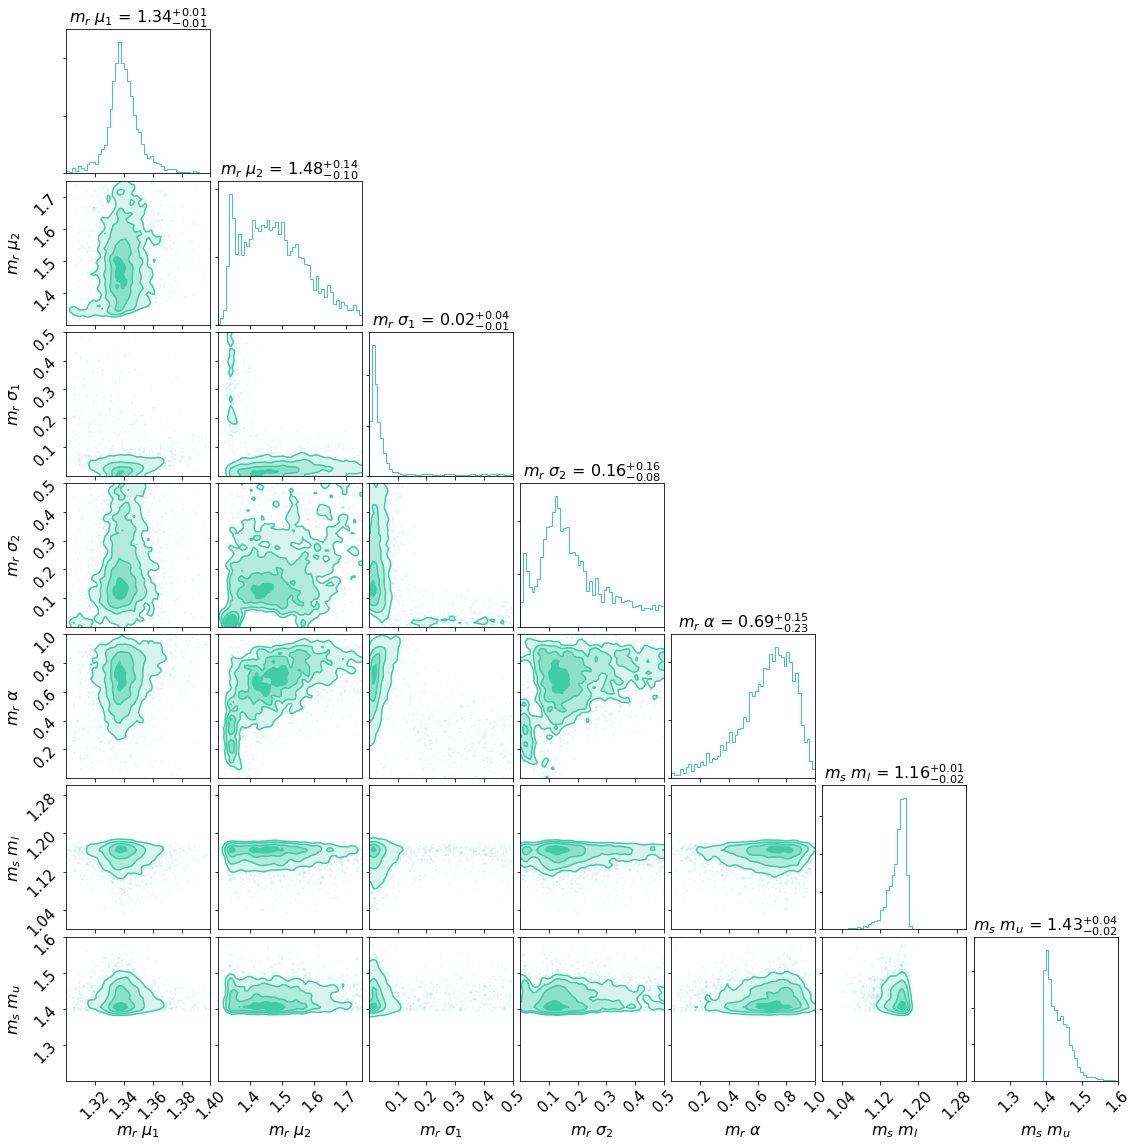

In [14]:
# We have to reset the model information back to hypothesis 1 information
modelName1, modelEval1, ndim1, paramNames1 = models.twoGaussianList
modelName2, modelEval2, ndim2, paramNames2 = models.uniformList
paramNames1 = [r'$m_r$ ' + pName for pName in paramNames1]
paramNames2 = [r'$m_s$ ' + pName for pName in paramNames2]

cornerPlot(hyp1Posterior[:,:ndim1 + ndim2], bounds=[[1.3,1.4],[1.3,1.75],[0,0.5],[0,0.5],[0,1], [1,1.3], [1.2,1.6]], parameterNames=paramNames1+paramNames2).show()

## Posterior Predictive Distributions (PPD)

The goal is to now summarise the findings into a mass distributions from our inference sampling.

We can see above that some parameter distributions cover a wide range of possible values. It would be unwise to take take the maximum likelihood parameters or the mode parameters (maximum a posteriori (MAP) estimate), as this would ignore the uncertainties within each parameter.

Instead we take another approach by creating a posterior predictive distibution:
See paper or https://en.wikipedia.org/wiki/Posterior_predictive_distribution.

In [15]:
def postPredDist(model1List, model2List, hypPost, plotrange=[0.8, 2], thinningFactor=10):
    paramList = hypPost[:,:-1].tolist()
    
    # Randomly take totalSamples/thinningFactor sets of the hyperparameters from the posterior.
    drawnParams = [random.choice(paramList) for i in range(len(paramList)/thinningFactor)]
    
    # Here we are creating two PPDs, one for recycled NS and one for non recycled NS.
    # We need to keep track of whether we are looking at reclyed or non-reclyed model parameters.
    paramsPassed = 0
    
    titleList = [r'Recycled NS Posterior Predictive Distribution $m_r$ - {}', r' Non-Recyled Posterior Predictive Distribution $m_s$ - {}']
    
    # Loop over each model for recycled and non-recycled
    for index, (modelName, modelEval, ndim, paramNames) in enumerate([model1List, model2List]):
        
        # X-axis plot range
        xValues = np.linspace(plotrange[0], plotrange[1], 10000)
        plt.xlim(plotrange[0], plotrange[1])
        
        # For each set of hyperparameters we evaluate the function they describe.
        yValueList = []
        for params in drawnParams:
            yValues = modelEval(params[paramsPassed:paramsPassed + ndim], xValues)
            yValueList.append(yValues)
        
        # We incriment paramsPassed by the number of parameters belonging to this model.
        paramsPassed += ndim
    
        # We turn these function values into an array and then take the mean of each function value at each x.
        yValueArray = np.asarray(yValueList)
        meanyValues = np.mean(yValueArray, axis=0)

        plt.title(titleList[index].format(modelName))
        plt.plot(xValues, meanyValues)
        plt.show()
    
    return

## Hypothesis #1 PPD

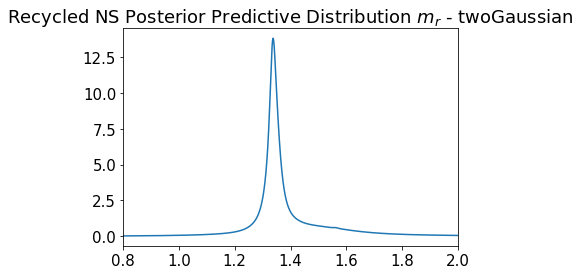

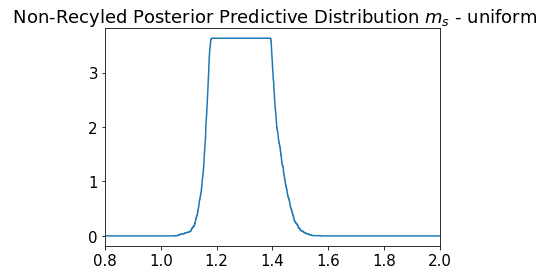

In [16]:
postPredDist(models.twoGaussianList, models.uniformList, hyp1Posterior)

## Hypothesis #2 PPD

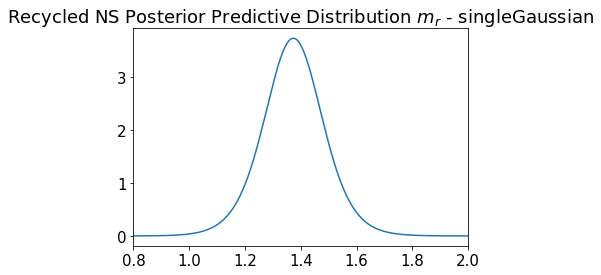

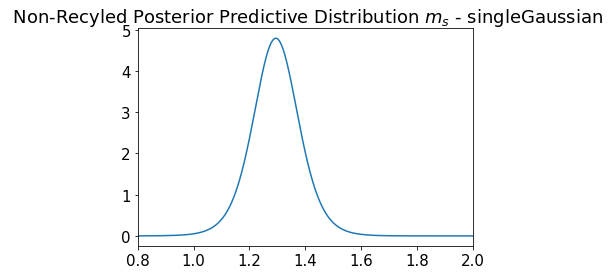

In [17]:
postPredDist(models.singleGaussianList, models.singleGaussianList, hyp2Posterior)